In [1]:
import msrvxc
import numpy as np
import pickle

import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from tqdm import tqdm

from astroquery.sdss import SDSS
from astroquery.gaia import Gaia

test


In [2]:
from Payne import utils as payne_utils

c_kms = 2.99792458e5 # speed of light in km/s

with open('grids/interp_bosz.pkl', 'rb') as f:
    interp_bosz = pickle.load(f)
    
with open('grids/interp_bosz_norm.pkl', 'rb') as f:
    interp_bosz_norm = pickle.load(f)
    
wvl = np.load('grids/wavl.npy')

def simulate_spec(interpolator, interp_wvl, wl, params):
    teff, logg, Z, rv = (params['teff'], params['logg'], params['z'], params['RV'])
    
    wl = wl * np.sqrt((1 - rv/c_kms)/(1 + rv/c_kms))
    
    return payne_utils.smoothing.smoothspec(wl, np.interp(wl, interp_wvl, interpolator( (teff, logg, Z, 0) )), resolution = 3000, smoothtype="R")

def continuum_normalize(wl, fl, ivar = None, avg_size = 150, ret_cont = False):
    
    fl_norm = np.zeros(np.size(fl))
    fl_cont = np.zeros(np.size(fl))
    
    ivar_yes = 0
    if ivar is not None:
        ivar_yes = 1
        ivar_norm = np.zeros(np.size(fl))
        
    for i in range(np.size(wl)):
        wl_clip = ((wl[i]-avg_size/2)<wl) * (wl<(wl[i]+avg_size/2))
        fl_cont[i] = np.median(fl[wl_clip])
        if ivar_yes:
            ivar_norm[i] = ivar[i]*np.median(fl[wl_clip])**2
    
    fl_norm = fl/fl_cont
    
    if ret_cont:
        if ivar_yes:
            return wl, fl_norm, ivar_norm, fl_cont
        else:
            return wl, fl_norm, fl_cont
    else:
        if ivar_yes:
            return wl, fl_norm, ivar_norm
        else:
            return wl, fl_norm

In [3]:
prefix = '../gravitational-redshift/'
catalog = Table.read(prefix + 'data/apo.fits')

def strip(catalog):  
    drop_cols = []
    keep_cols = ['ms_source_id', 'ms_ra', 'ms_dec', 'ms_plate', 'ms_mjd', 'ms_fiberid', 'ms_filepath', 'ms_rv_from', 'radial_velocity', 'radial_velocity_error']
        
    for key in catalog.keys():
        if key not in keep_cols:
            drop_cols.append(key)
            
    catalog.remove_columns(drop_cols)
    
    return catalog

catalog = strip(catalog)

In [4]:
catalog

ms_source_id,ms_ra,ms_dec,ms_filepath,ms_rv_from,ms_plate,ms_mjd,ms_fiberid,radial_velocity,radial_velocity_error
int64,float64,float64,bytes31,bytes3,float64,float64,float64,float64,float64
707673622400826112,128.47104205409858,29.25025192006539,apo/process_ms/WD0833+2915.fits,apo,0.0,0.0,0.0,-999.0,-999.0
3262517841635204608,51.29441139145818,-1.1874405862375654,apo/process_ms/WD0325-0111.fits,apo,0.0,0.0,0.0,-999.0,-999.0
3938576068034642688,200.82491134045316,17.994533311699048,apo/process_ms/WD1323+1759.fits,apo,0.0,0.0,0.0,-999.0,-999.0
944149264678061056,102.59946498955337,37.91056578041305,apo/process_ms/WD0650+3754.fits,apo,0.0,0.0,0.0,-999.0,-999.0


In [5]:
plt.style.use(prefix + 'stefan.mplstyle')
#
#wl = []
#fl = []
#ivar = []
#
#for i in tqdm(range(len(catalog))):
#    
#    
#    wl.append(t_wl)
#    fl.append(t_fl)
#    ivar.append(t_ivar)
#        
#    plt.figure(figsize=(10, 3))
#    plt.plot(t_wl, t_fl)
#    
#catalog['wl'] = wl
#catalog['fl'] = fl
#catalog['ivar'] = ivar

 25%|█████████████████████▎                                                               | 1/4 [00:05<00:17,  5.68s/it]

0.1287057723501055
22.326981456218377
16218.498717117176


 50%|██████████████████████████████████████████▌                                          | 2/4 [00:12<00:12,  6.32s/it]

0.18010644210718507
16.54080203740009
27716.18706836724


 75%|███████████████████████████████████████████████████████████████▊                     | 3/4 [00:19<00:06,  6.48s/it]

0.019945103377608388
5.007845719184382
14997.270994839426


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:25<00:00,  6.42s/it]

0.2193495391300279
35.995296880729356
26197.88077056775


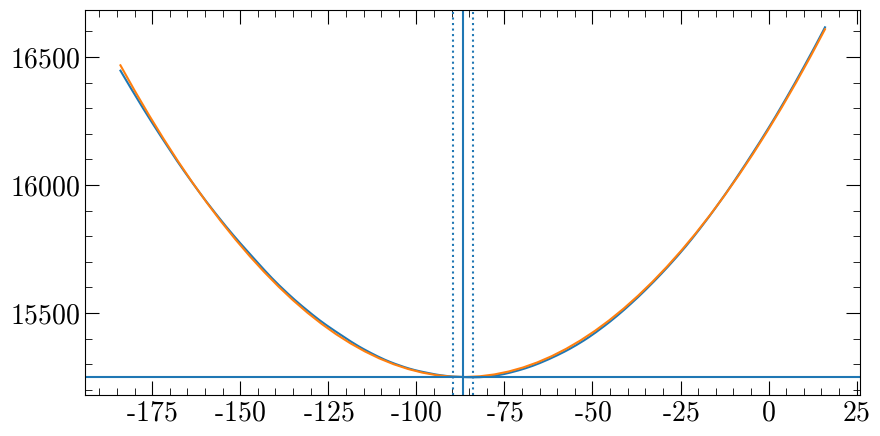

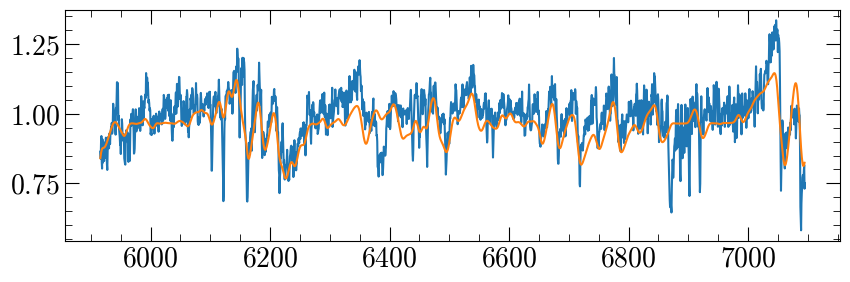

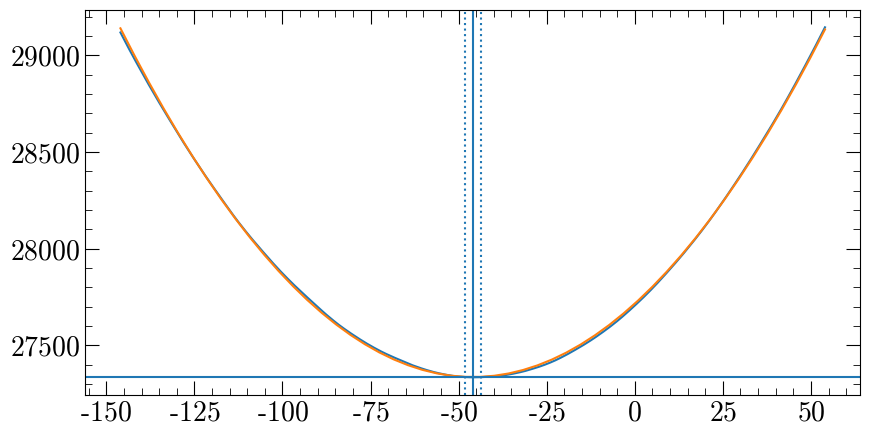

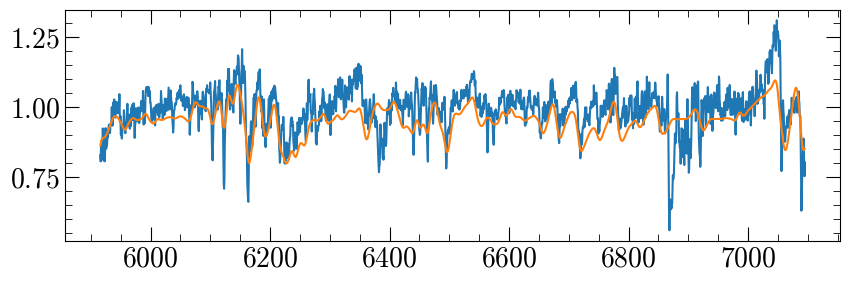

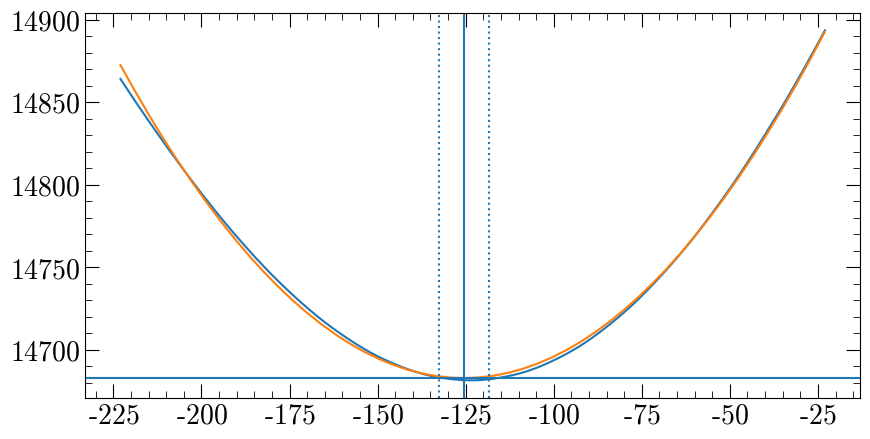

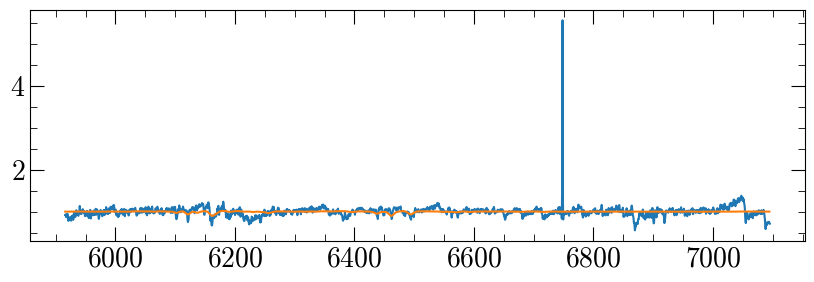

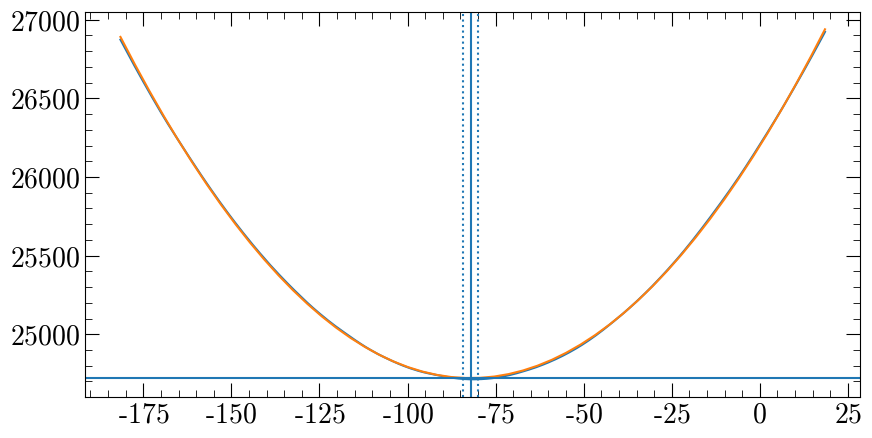

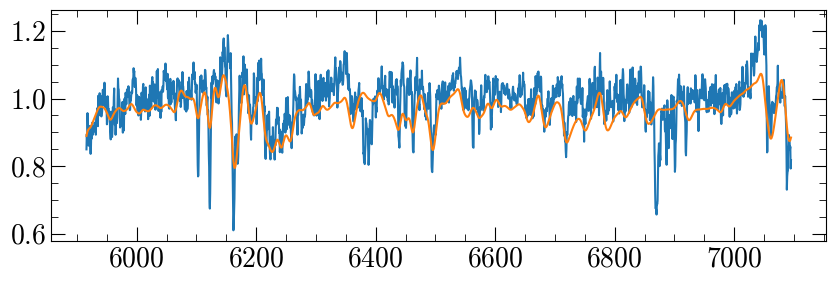

In [9]:
rvs = []
e_rvs = []
redchis = []

for i in tqdm(range(len(catalog))):
    spec = fits.open(prefix + catalog['ms_filepath'][i])
    
    t_wl = spec[0].data[0]
    t_fl = spec[0].data[1]
    t_ivar = spec[0].data[2]
    
    t_wl, t_fl, t_ivar = continuum_normalize(t_wl, t_fl, t_ivar)
    
    rv, e_rv, redchi, res = msrvxc.fit.fit_rv(interp_bosz_norm, wvl, t_wl, t_fl, t_ivar, plot = True)
    
    plt.figure(figsize = (10,3))
    
    res.params['RV'].value = rv
    
    plt.plot(t_wl, t_fl, label = 'Observed')
    plt.plot(t_wl, simulate_spec(interp_bosz_norm, wvl, t_wl, res.params), alpha = 1, label = 'Model')
    
    rvs.append(rv)
    e_rvs.append(e_rv)
    redchis.append(redchi)
    
catalog['radial_velocity'] = rvs
catalog['radial_velocity_error'] = e_rvs
catalog['ms_redchi'] = redchis
catalog['ms_gaia'] = np.zeros(len(catalog))
catalog['ms_rv_id'] = [414+i for i in range(len(catalog))]

In [10]:
catalog

ms_source_id,ms_ra,ms_dec,ms_filepath,ms_rv_from,ms_plate,ms_mjd,ms_fiberid,radial_velocity,radial_velocity_error,ms_redchi,ms_gaia,ms_rv_id
int64,float64,float64,bytes31,bytes3,float64,float64,float64,float64,float64,float64,float64,int64
707673622400826112,128.47104205409858,29.25025192006539,apo/process_ms/WD0833+2915.fits,apo,0.0,0.0,0.0,-86.73651946038797,2.7874108580236268,7.501198020699944,0.0,414
3262517841635204608,51.29441139145818,-1.1874405862375654,apo/process_ms/WD0325-0111.fits,apo,0.0,0.0,0.0,-45.91951804687896,2.356326006073399,13.445651833836378,0.0,415
3938576068034642688,200.82491134045316,17.994533311699048,apo/process_ms/WD1323+1759.fits,apo,0.0,0.0,0.0,-125.54073108506674,7.080792278956693,7.221674819133394,0.0,416
944149264678061056,102.59946498955337,37.91056578041305,apo/process_ms/WD0650+3754.fits,apo,0.0,0.0,0.0,-82.05008550164256,2.13516595902081,12.156170127183035,0.0,417
